# Data Input

In [1]:
import numpy as np
from copy import deepcopy
from spglm.iwls import iwls, _compute_betas_gwr
from spglm.family import *
from mgwr.search import golden_section
import pandas as pd
import statsmodels.api as sm
import geopandas as gp
import matplotlib.pyplot as plt
import libpysal.weights as sw
import time

import time
import urllib
import copy
from copy import deepcopy

from spint.gravity import Gravity, Production, Attraction, Doubly 

In [4]:
austria = pd.read_csv('Data/austria.csv')
austria_shp = gp.read_file('Data/austria.shp')
austria = austria[austria['Origin'] != austria['Destination']]

In [5]:
aust_plcdf = austria[['Destination','Dj']]
aust_plcdf = aust_plcdf.drop_duplicates(subset = ['Destination'])

In [6]:
austria.head(1)

,Unnamed: 0,Origin,Destination,Data,Oi,Dj,Dij
1,1,AT11,AT12,1131,4016,25741,103.001845


# Terms Class

## Linear

In [7]:
class LinearTerm():
    
    def __init__(self, df, *idx):
        
        self._df = df
        #self._df = self._df.assign(intercept = 1)
        self._idx = list(idx) 
        #self._idx.insert(0, -1)
        self._x = self._df.iloc[:, self._idx].apply(pd.to_numeric).values

        # int(self._df.shape[1]-1) self._x = np.column_stack((ones, self._x))
                  
    @property
    def X(self):
        return self._x
    
    def __str__(self):
        return '<%s, %s:%s>' % (self.__class__.__name__)

        

## Spatial Access

In [569]:
class SpatialAccessTerm():
    
    def __init__(self, df, geomap, plcdf, *idx_codes, idx_mpn = 0, idx_plcn = 0, idx_plca = 1):
    
        tdf = df.iloc[:, list(idx_codes)]
        tdf = tdf.assign(Origin = tdf.iloc[:,0],
                         Destination = tdf.iloc[:,1])
        mp = geomap.set_index(geomap.iloc[:, idx_mpn])
    
        #calculate distances
        distmat = sw.distance.DistanceBand.from_dataframe(mp, threshold=99999, binary=False, alpha=1)
        distmat = distmat.full()[0]
        distmat = distmat[distmat != 0].reshape((plcdf.shape[0], plcdf.shape[0]-1))
        
        def get_mk(plcn):
            tmpdf = plcdf[plcdf.iloc[:,idx_plcn] != plcn]
            mk = tmpdf.iloc[:,idx_plca].values.reshape((1,-1))
            return mk
    
        tplcdf = plcdf.set_index(plcdf.iloc[:,idx_plcn].reindex(geomap.iloc[:, idx_mpn]))#sort_index()
        #print(plcdf)#sort_index())
        
        tplcdf = tplcdf.assign(rownum = np.arange(tplcdf.shape[0]))
        tplcdf = tplcdf.assign(dkj = tplcdf.iloc[:,-1].apply(lambda x: distmat[x]),
                               mk = tplcdf.iloc[:,0].apply(lambda x: get_mk(x)))

        findf = tplcdf[[tplcdf.columns[idx_plcn],'mk', 'dkj']].set_index(tplcdf.iloc[:,idx_plcn])
        access_df = tdf.join(findf, how = 'left', on = 'Destination', rsuffix = '_r') 
        self._mk = access_df.mk
        self._dkj = access_df.dkj
        self._df = access_df
    
    def cal(self, sigma, logged = False):
        
        def cal_Access(a, b, sigma):
            aij = np.dot(a, np.power(b, sigma))
            return aij
        
        Aijs = np.vectorize(cal_Access)(self._mk, self._dkj, sigma)
        Aijs = pd.to_numeric(Aijs).reshape((-1,1))
        
        if logged == True:
            Aijs = np.log(Aijs)
        
        return Aijs
         
    @property
    def mk(self):
        return self._mk
    
    @property
    def dkj(self):
        return self._dkj
    
    @property
    def df(self):
        return self._df
    
    def __str__(self):
        return '<%s, %s:%s>' % (self.__class__.__name__)
    

# GASM Class

In [611]:
class GASM():
    lin = False
    sa = False

    def __init__(self, *terms):
        for term in terms:
            if isinstance(term, LinearTerm):
                self._lt = term.X
                self.lin = True
            if isinstance(term, SpatialAccessTerm):
                self._sat = term
                self.sa = True
    
    def calibrate(self, value, intercept = True):
        
        def backfit(y, X, w, verbose = False):
            n,k = X.shape

            betas = _compute_betas_gwr(y, X, w.reshape((-1, 1)))[0]
            #betas = sm.OLS(y, (np.log(w * X))).fit().params.reshape((-1,1))
            XB = np.multiply(betas.T, X)
            yhat = np.dot(X, betas)
            err = y.reshape((-1, 1)) - yhat
            iters = 0
            scores = []
            delta = 1e6
            tol = 1e-8
            max_iter = 50

            for iters in range(1, max_iter + 1):
                new_XB = np.zeros_like(X)
                params = np.zeros_like(betas)
                for j in range(k):
                    temp_y = XB[:, j].reshape((-1, 1))
                    temp_y = temp_y + err.reshape((-1, 1))
                    temp_X = X[:, j].reshape((-1, 1))  
                    #beta = sm.OLS(temp_y, (np.log(w * temp_X))).fit().params[0]
                    beta = _compute_betas_gwr(temp_y, temp_X, w.reshape((-1, 1)))[0]
                    yhat = np.dot(temp_X, beta)
                    new_XB[:, j] = yhat.flatten()
                    err = (temp_y - yhat).reshape((-1, 1))
                    params[j, :] = beta[0][0]
                
                num = np.sum((XB-new_XB)**2)
                den = 1 + np.sum(np.sum(XB, axis=1)**2)
                score = (num / den)
                XB = new_XB
        
                scores.append(deepcopy(score))
                delta = score

                if verbose:
                    print("Current iteration:", iters, ",SOC:", np.round(score, 8))
                if delta < tol:
                    break

            return params, X
            
        
        def backfitCD(y, X, w, sat, verbose = False):
            n,k = X.shape

            #print(X)
            betas = _compute_betas_gwr(y, X, w.reshape((-1, 1)))[0]
            #print(betas)
            XB = np.multiply(betas.T, X)
            yhat = np.dot(X, betas)
            err = y.reshape((-1, 1)) - yhat
            iters = 0
            scores = []
            delta = 1e6
            tol = 1e-8
            max_iter = 50
            sig = 9999

            for iters in range(1, max_iter + 1):
                new_XB = np.zeros_like(X)
                params = np.zeros_like(betas)

                for j in range(k):
                    temp_y = XB[:, j].reshape((-1, 1))
                    temp_y = temp_y + err.reshape((-1, 1))
                    temp_X = X[:, j].reshape((-1, 1))

                    if j == k-1:
                        #score = lambda x: sm.OLS(temp_y, sat.cal(x, True)).fit().aic
                        score = lambda x: sm.OLS(temp_y, np.hstack((X[:, 0:j-1], sat.cal(x, True)))).fit().aic
                        sig  = golden_section(-6, 6, 0.3879, score, 1e-8, 50)[0] #0.3879
                        #print(sig)
                        Aij = sat.cal(sig)
                        X[:, j] = np.log(Aij.flatten())
                        temp_X = np.log(Aij.flatten()).reshape((-1,1))#sat.cal(sig, True)#np.log(Aij).reshape((-1,1))

                    #beta = sm.OLS(temp_y, (np.log(w * temp_X))).fit().params[0]
                    beta = _compute_betas_gwr(temp_y, temp_X, w.reshape((-1, 1)))[0]
                    #print(beta)
                    yhat = np.dot(temp_X, beta)
                    new_XB[:, j] = yhat.flatten()
                    err = (temp_y - yhat).reshape((-1, 1))
                    params[j, :] = beta[0][0]
                
                num = np.sum((XB-new_XB)**2)
                den = 1 + np.sum(np.sum(XB, axis=1)**2)
                score = (num / den)
                XB = new_XB
        
                scores.append(deepcopy(score))
                delta = score

                if verbose:
                    print("Current iteration:", iters, ",SOC:", np.round(score, 8))
                if delta < tol:
                    break

            return params, X, sig
        
        X = np.zeros_like(self._lt)
        ones = pd.to_numeric(np.ones(X.shape[0])).reshape((-1,1))
        
        if intercept == True:
        
            if self.lin == True and self.sa == False:
                X = np.hstack((ones, np.log(self._lt)))
            
            if self.lin == True and self.sa == True:
                X = np.hstack((ones, np.log(self._lt), self._sat.cal(-1, True)))
                
        if intercept == False:
            if self.lin == True and self.sa == False:
                X = np.log(self._lt)
            
            if self.lin == True and self.sa == True:
                X = np.hstack((np.log(self._lt), self._sat.cal(-1, True)))
            
        self._initX = X

        y = value.reshape((-1,1))
        s_0 = np.log(np.mean(y))
        eta = s_0.reshape((-1, 1))
        s_old = np.ones_like(X)
        crit = 9999
        betas = np.ones(self._initX.shape[1])
        sigma = 9999

        while crit > 1e-8:
            mu = np.exp(eta).reshape((-1, 1))
            w = mu.reshape((-1,1))
            z = eta + ((y.reshape((-1, 1)) - mu) / mu)
            
            if self.lin == True and self.sa == False:
                betas, X = backfit(z, X, w)
            if self.lin == True and self.sa == True:
                betas, X, sigma  = backfitCD(z, X, w, self._sat)
            
            s_new = np.multiply(betas.T, X)
            inner = np.sum((s_old - s_new)**2, axis=1)
            num = np.sum(w*inner)
            den = np.sum(w*np.sum((1 + s_old)**2, axis=1).reshape((-1, 1)))
            crit = num / den
            eta = np.sum(s_new, axis=1).reshape((-1, 1))
            s_old = s_new
        
        if self.lin == True and self.sa == False:
            return betas
        if self.lin == True and self.sa == True:
            return betas, sigma

    
    @property
    def initX(self):
        return self._initX


# Simulation

## Create Points

Refer to: https://pysal.org/notebooks/explore/pointpats/process.html#Point-Processes

In [266]:
from pointpats import * #PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import *
%matplotlib inline
#import matplotlib.pyplot as plt

### Even

In [267]:
x = np.arange(20, 120, 20)
x

array([ 20,  40,  60,  80, 100])

In [268]:
X_eve = np.tile(x, 5)
Y_eve = np.repeat(x, 5)

In [269]:
squpts_even = np.column_stack((X_eve, Y_eve))

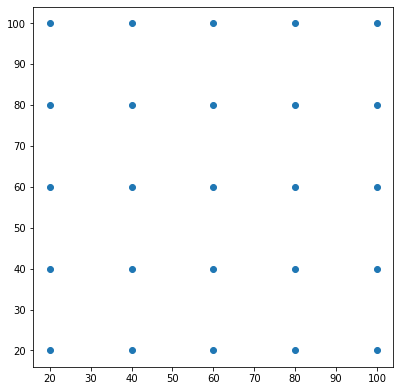

In [270]:
len_xaxis,len_yaxis = 5,5
xspace, yspace = 1, 1
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace
plt.figure(figsize=(x_fig,y_fig))
plt.subplots_adjust(left=1-xspace, right = xspace, top=yspace, bottom = 1-yspace)
plt.plot(X_eve, Y_eve, 'o')

### Setup for the below

In [271]:
square = Polygon([Point((20, 20)), Point((100, 20)), Point((100, 100)), Point((20, 100))])
squwin = as_window(square)

### Random

Generate a point series from N-conditioned CSR 

In [272]:
# simulate a csr process in the same window (200 points, 1 realization)
# by specifying "asPP" false, we can generate a point series
# by specifying "conditioning" false, we can simulate a N-conditioned CSR
np.random.seed(5)
squsamples = PoissonPointProcess(squwin, 25, 1, conditioning=False, asPP=False)
#squsamples.realizations[0] # simulated randomt points

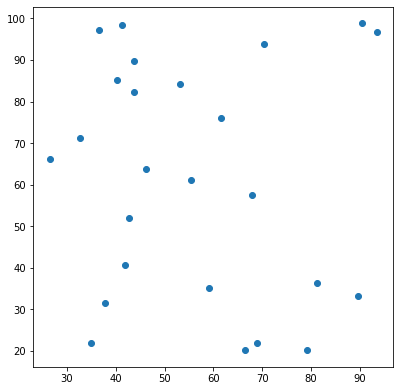

In [273]:
# build a point pattern from the simulated point series
squpts_random = squsamples.realizations[0]
len_xaxis,len_yaxis = 5,5
xspace, yspace = 1, 1
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace
plt.figure(figsize=(x_fig,y_fig))
plt.subplots_adjust(left=1-xspace, right = xspace, top=yspace, bottom = 1-yspace)
plt.plot(squpts_random[:,0],squpts_random[:,1],'o')
#squpts_random.plot(window=True, hull=True, title='Random Point Pattern')

### Cluster

1. Simulate a Poisson cluster process of size 75 with 5 parents and 15 children within 0.5 units of each parent (parent randomts:  $\lambda$-conditioned CSR)

In [274]:
np.random.seed(10)
squcsamples = PoissonClusterPointProcess(squwin, 25, 5, 50, 1, asPP=False, conditioning=True)

2. Generate a point series from N-conditioned CSR with a random pattern

In [275]:
np.random.seed(10)
squsamples2 = PoissonPointProcess(squwin, 5, 1, conditioning=False, asPP=False)
squpts_cluster = np.row_stack((squcsamples.realizations[0], squsamples2.realizations[0]))

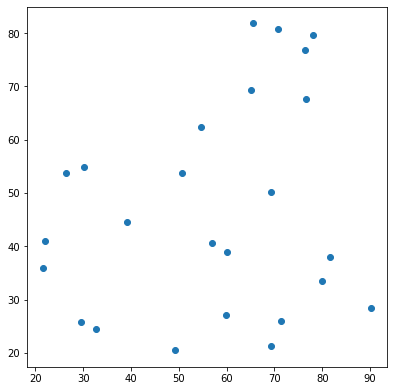

In [276]:
len_xaxis,len_yaxis = 5,5
xspace, yspace = 1, 1
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace
plt.figure(figsize=(x_fig,y_fig))
plt.subplots_adjust(left=1-xspace, right = xspace, top=yspace, bottom = 1-yspace)
plt.plot(squpts_cluster[:,0],squpts_cluster[:,1],'o')
#squpts_cluster = PointPattern(squfin_cluster)
#squpts_cluster.plot(window=True, hull=True, title='Clustered Point Pattern with Some Random Points')

In [277]:
squpts_cluster.shape

(25, 2)

## Build Data

In [278]:
evendf = pd.DataFrame(squpts_even, columns = ['Lon', 'Lat'])
randomdf = pd.DataFrame(squpts_random, columns = ['Lon', 'Lat'])
clusterdf = pd.DataFrame(squpts_cluster, columns = ['Lon', 'Lat'])

In [279]:
evendf = evendf.assign(Name = np.arange(evendf.shape[0]))
randomdf = randomdf.assign(Name = np.arange(randomdf.shape[0]))
clusterdf = clusterdf.assign(Name = np.arange(clusterdf.shape[0]))

evendf.Name = evendf.Name.astype(str).str.zfill(3)
randomdf.Name = randomdf.Name.astype(str).str.zfill(3)
clusterdf.Name = clusterdf.Name.astype(str).str.zfill(3)

In [280]:
clusterdf.head(1)

,Lon,Lat,Name
0,49.236338,20.468584,000


In [281]:
import geopandas as gpd

In [282]:
#create geodataframe
even_gdf = gpd.GeoDataFrame(evendf, geometry=gpd.points_from_xy(evendf.Lon, evendf.Lat))
random_gdf = gpd.GeoDataFrame(randomdf, geometry=gpd.points_from_xy(randomdf.Lon, randomdf.Lat))
cluster_gdf = gpd.GeoDataFrame(clusterdf, geometry=gpd.points_from_xy(clusterdf.Lon, clusterdf.Lat))

### Population

In [283]:
np.random.seed(5)
pop = np.random.uniform(50000,5000000,25)
popdf = evendf.assign(Pop = pop)
popdf = popdf[['Name', 'Pop']]

### Distance

Euclidean distance

In [285]:
even_dist_mat = np.linalg.norm(squpts_even - squpts_even[:,None], axis=-1)
random_dist_mat = np.linalg.norm(squpts_random - squpts_random[:,None], axis=-1)
cluster_dist_mat = np.linalg.norm(squpts_cluster - squpts_cluster[:,None], axis=-1)

In [286]:
even_dists = even_dist_mat[even_dist_mat != 0].reshape((-1,1))
random_dists = random_dist_mat[random_dist_mat != 0].reshape((-1,1))
cluster_dists = cluster_dist_mat[cluster_dist_mat != 0].reshape((-1,1))

In [287]:
tmpdf = randomdf.copy()
tmpdf = tmpdf.set_index(tmpdf.Name).sort_index()

places = tmpdf.Name.values.reshape((-1,1))
tmp_orig = np.repeat(places, len(places)).reshape((-1,1))
tmp_dest = np.tile(places, (len(places),1))
tmp_codes_df = pd.DataFrame(np.column_stack((tmp_orig, tmp_dest)))
mask = tmp_codes_df.iloc[:,0] != tmp_codes_df.iloc[:,1]
fcodes = tmp_orig + tmp_dest
fcodes = fcodes[mask].reshape((-1,1))

even_dist_df = pd.DataFrame(np.column_stack((fcodes, even_dists)), columns = ['fcode', 'Distance'])
random_dist_df = pd.DataFrame(np.column_stack((fcodes, random_dists)), columns = ['fcode', 'Distance'])
cluster_dist_df = pd.DataFrame(np.column_stack((fcodes, cluster_dists)), columns = ['fcode', 'Distance'])

### Combine Data

In [288]:
simul = pd.DataFrame(fcodes, columns = ['Code'])
simul = simul.assign(Origin = simul.Code.str[:3],
                     Destination = simul.Code.str[3:],
                     Flows = np.ones(simul.shape[0]).reshape((-1,1)))

In [289]:
simul = simul.join(popdf.set_index(popdf.Name), how = 'left', on = 'Origin')
simul = simul.drop(['Name'], axis = 1)
simul = simul.rename(columns = {'Pop': 'Propulsive'})

simul = simul.join(popdf.set_index(popdf.Name), how = 'left', on = 'Destination')
simul = simul.drop(['Name'], axis = 1)
simul = simul.rename(columns = {'Pop': 'Attractive'})

In [290]:
even_simul = simul.copy()
random_simul = simul.copy()
cluster_simul = simul.copy()

In [291]:
even_simul = even_simul.join(even_dist_df.set_index(even_dist_df.fcode), how = 'left', on = 'Code')
even_simul = even_simul.drop(['fcode'], axis = 1)
even_simul = even_simul.set_index(even_simul.Code)
even_simul = even_simul.drop(['Code'], axis = 1)

random_simul = random_simul.join(random_dist_df.set_index(random_dist_df.fcode), how = 'left', on = 'Code')
random_simul = random_simul.drop(['fcode'], axis = 1)
random_simul = random_simul.set_index(random_simul.Code)
random_simul = random_simul.drop(['Code'], axis = 1)

cluster_simul = cluster_simul.join(cluster_dist_df.set_index(cluster_dist_df.fcode), how = 'left', on = 'Code')
cluster_simul = cluster_simul.drop(['fcode'], axis = 1)
cluster_simul = cluster_simul.set_index(cluster_simul.Code)
cluster_simul = cluster_simul.drop(['Code'], axis = 1)

In [292]:
even_simul.head(1)

,Origin,Destination,Flows,Propulsive,Attractive,Distance
Code,,,,,,
000001,000,001,1.0,1.148866e+06,4.360125e+06,20.0


In [293]:
random_simul.head(1)

,Origin,Destination,Flows,Propulsive,Attractive,Distance
Code,,,,,,
000001,000,001,1.0,1.148866e+06,4.360125e+06,51.927488


In [294]:
cluster_simul.head(1)

,Origin,Destination,Flows,Propulsive,Attractive,Distance
Code,,,,,,
000001,000,001,1.0,1.148866e+06,4.360125e+06,21.376667


### Accessibility

In [606]:
even_sa = SpatialAccessTerm(even_simul, even_gdf, popdf,  0, 1, idx_mpn = 2 )
random_sa = SpatialAccessTerm(random_simul, random_gdf, popdf,  0, 1, idx_mpn = 2)
cluster_sa = SpatialAccessTerm(cluster_simul, cluster_gdf, popdf,  0, 1, idx_mpn = 2)

In [296]:
even_simul = even_simul.assign(Aij = even_sa.cal(-3))
random_simul = random_simul.assign(Aij = random_sa.cal(-3))
cluster_simul = cluster_simul.assign(Aij = cluster_sa.cal(-3))

### Flows

$T_{ij} = kV_{i}^{\mu}W_{j}^{\alpha}d_{ij}^{\beta}A_{ij}^{\delta}$

In [769]:
betas = np.array([[1], [1], [-1], [-1]])

ones = np.ones(even_simul.shape[0]).reshape((-1,1))

evenl = LinearTerm(even_simul, 4, 5, 6)
randoml = LinearTerm(random_simul, 4, 5, 6)
clusterl = LinearTerm(cluster_simul, 4, 5, 6)

tX_even = np.hstack((ones, np.log(evenl.X))) #np.log(evenl.X) #
tX_random = np.hstack((ones, np.log(randoml.X))) #np.log(randoml.X) #
tX_cluster = np.hstack((ones, np.log(clusterl.X))) #np.log(clusterl.X) #

f_even = np.exp(np.dot(tX_even, betas))
f_random = np.exp(np.dot(tX_random, betas))
f_cluster = np.exp(np.dot(tX_cluster, betas))

fsum_even = np.sum(f_even)
fsum_random = np.sum(f_random)
fsum_cluster = np.sum(f_cluster)


In [770]:
even_simul = even_simul.assign(f = f_even)
random_simul = random_simul.assign(f = f_random)
cluster_simul = cluster_simul.assign(f = f_cluster)

In [771]:
even_simul = even_simul.assign(prob = even_simul.f/fsum_even)
random_simul = random_simul.assign(prob = random_simul.f/ fsum_random )
cluster_simul = cluster_simul.assign(prob = cluster_simul.f/ fsum_cluster)

## Simulating

### iwls with X1, X2

In [760]:
X1 = LinearTerm(even_simul, 4).X # population
X2 = LinearTerm(even_simul, 5).X # distance

f_even1 = np.exp(5 + np.log(X1)* 1 + np.log(X2)*(-1))
even_simul = even_simul.assign(f1 = f_even1)
fsum_even1 = np.sum(f_even1)
even_simul = even_simul.assign(prob1 = even_simul.f1/fsum_even1)

f_even2 = np.exp(5) * (X1**1) * (X2** (-1))
even_simul = even_simul.assign(f2 = f_even2)
fsum_even2 = np.sum(f_even2)
even_simul = even_simul.assign(prob2 = even_simul.f2/fsum_even2)

In [761]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = even_simul.f1)
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 5.],
       [ 1.],
       [-1.]])

In [762]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob1))
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[-3.52530161],
       [ 1.00244446],
       [-0.99842176]])

In [720]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = even_simul.f2)
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 5.],
       [ 1.],
       [-1.]])

In [721]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob2))
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[-3.52530161],
       [ 1.00244446],
       [-0.99842176]])

### iwls with X1, X2, X3

In [731]:
X1 = LinearTerm(even_simul, 4).X
X2 = LinearTerm(even_simul, 5).X
X3 = LinearTerm(even_simul, 6).X # accessibility with sigma as -3

f_even1 = np.exp(5 + np.log(X1)* 1 + np.log(X2)*(-1) + np.log(X3)*(-1))
even_simul = even_simul.assign(f1 = f_even1)
fsum_even1 = np.sum(f_even1)
even_simul = even_simul.assign(prob1 = even_simul.f1/fsum_even1)

f_even2 = np.exp(5) * (X1**1) * (X2** (-1)) * (X3** (-1))
even_simul = even_simul.assign(f2 = f_even2)
fsum_even2 = np.sum(f_even2)
even_simul = even_simul.assign(prob2 = even_simul.f2/fsum_even2)

In [745]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = even_simul.f1)
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2), np.log(X3)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 5.],
       [ 1.],
       [-1.],
       [-1.]])

In [746]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob1))
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2), np.log(X3)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 3.78420395],
       [ 0.99722042],
       [-1.00208049],
       [-1.00275011]])

In [747]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = even_simul.f2)
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2), np.log(X3)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 5.],
       [ 1.],
       [-1.],
       [-1.]])

In [748]:
np.random.seed(0)
even_simul = even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob2))
w = ones

tX_even = np.hstack((ones, np.log(X1), np.log(X2), np.log(X3)))
iwls(even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]

array([[ 3.78420395],
       [ 0.99722042],
       [-1.00208049],
       [-1.00275011]])

In [729]:
tmp_even_simul = even_simul.copy()
tbli_even = [] # all coefficients
tX_even = np.hstack((ones, np.log(X1), np.log(X2), np.log(X3)))

for i in range(10):
    np.random.seed(i)
    tmp_even_simul = tmp_even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob1))
    tmp_betas_even = iwls(tmp_even_simul.Flows.values.reshape((-1,1)), tX_even, family=Poisson(), offset=w.reshape((-1, 1)), y_fix=None, wi=w.reshape((-1, 1)))[0]
    tbli_even.append(tmp_betas_even)
    #sli_even.append(tmp_sigma_even)  

In [730]:
tbli_even

[array([[ 3.78420395],
        [ 0.99722042],
        [-1.00208049],
        [-1.00275011]]),
 array([[ 3.68406478],
        [ 1.00192348],
        [-1.00079438],
        [-0.99913863]]),
 array([[ 3.74260969],
        [ 0.99853137],
        [-0.9976495 ],
        [-1.00190678]]),
 array([[ 3.68909834],
        [ 0.99960294],
        [-0.99881326],
        [-0.99604738]]),
 array([[ 3.72311741],
        [ 0.99814456],
        [-0.99824976],
        [-0.99807299]]),
 array([[ 3.70988209],
        [ 0.99889008],
        [-0.99908848],
        [-0.99733783]]),
 array([[ 3.73953577],
        [ 0.99875362],
        [-1.00187593],
        [-0.99978147]]),
 array([[ 3.7866114 ],
        [ 0.9951513 ],
        [-0.99806119],
        [-1.00085188]]),
 array([[ 3.71645326],
        [ 1.00067247],
        [-0.99861651],
        [-1.002189  ]]),
 array([[ 3.7596518 ],
        [ 0.99978236],
        [-1.00102676],
        [-1.00515894]])]

### Even

In [785]:
np.random.seed(0)#10
even_simul = even_simul.assign(Flows = even_simul.f)
#even_simul = even_simul.assign(Flows = np.round(1000000 * even_simul.prob))
even_simul = even_simul.assign(Flows = np.random.multinomial(1000000, even_simul.prob))

In [786]:
even_l = LinearTerm(even_simul, 4, 5)
even_mod = GASM(even_l, even_sa)

In [787]:
betas_even, sigma_even = even_mod.calibrate(even_simul.Flows.values)

In [490]:
print(betas_even, sigma_even) #f sigma = -3

[[ 1.]
 [-1.]
 [-1.]] -3.0


In [784]:
print(betas_even, sigma_even) #multinomial 1000000 sigma = -3

[[ 3.7425099 ]
 [ 0.99712338]
 [-1.00203265]
 [-1.00129437]] -3.01


In [788]:
print(betas_even, sigma_even) #multinomial 5000000 sigma = -3

[[ 5.31531926]
 [ 1.00030231]
 [-1.00105098]
 [-0.99870198]] -3.0


In [359]:
tmp_even_simul = even_simul.copy()
bli_even = [] # all coefficients
sli_even = [] # sigma

for i in range(10):
    np.random.seed(i)
    tmp_even_simul.Flows = np.random.multinomial(1000000, even_simul.prob)
    tmp_betas_even, tmp_sigma_even = even_mod.calibrate(tmp_even_simul.Flows.values)
    bli_even .append(tmp_betas_even)
    sli_even.append(tmp_sigma_even)  

In [363]:
dcli_even = [] #distance decay beta
muli_even = [] #mu
ali_even = []  #accessibility
ili_even = []  #intercept

In [364]:
for i in range(10):
    ili_even.append(bli_even[i][0])
    muli_even.append(bli_even[i][1])
    dcli_even.append(bli_even[i][2])
    ali_even.append(bli_even[i][3])
    

In [370]:
sli_even

[-3.01, -3.0, -3.01, -3.02, -3.03, -3.05, -3.03, -3.03, -2.98, -2.94]

In [427]:
dcli_even

[array([-1.00203265]),
 array([-1.00079438]),
 array([-0.99760146]),
 array([-0.99871861]),
 array([-0.9981072]),
 array([-0.99884991]),
 array([-1.00173285]),
 array([-0.99791754]),
 array([-0.99871264]),
 array([-1.00131512])]

In [428]:
muli_even

[array([0.99712338]),
 array([1.00192348]),
 array([0.99843447]),
 array([0.99941]),
 array([0.99785432]),
 array([0.99840761]),
 array([0.9984634]),
 array([0.99486043]),
 array([1.00086588]),
 array([1.00036353])]

In [429]:
ili_even

[array([3.7425099]),
 array([3.68406478]),
 array([3.70093967]),
 array([3.60651661]),
 array([3.59929597]),
 array([3.50460608]),
 array([3.61545715]),
 array([3.66240546]),
 array([3.80048158]),
 array([4.01515103]),
 array([3.7425099])]

### Random

In [398]:
np.random.seed(0)
#random_simul = random_simul.assign(Flows = random_simul.f)
#random_simul = random_simul.assign(Flows = np.round(1000000 * random_simul.prob))
random_simul = random_simul.assign(Flows = np.random.multinomial(1000000, random_simul.prob))

In [399]:
random_l = LinearTerm(random_simul, 4, 5)
random_mod = GASM(random_l, random_sa)
betas_random, sigma_random = random_mod.calibrate(random_simul.Flows.values)

In [345]:
print(betas_random, sigma_random) #f sigma = -3

[[ 1.]
 [-1.]
 [-1.]] -3.0


In [400]:
print(betas_random, sigma_random) #multinomial sigma = -3

[[ 4.9167684 ]
 [ 0.99743921]
 [-1.00009459]
 [-0.99497175]] -3.01


In [413]:
tmp_random_simul = random_simul.copy()
bli_random = [] # all coefficients
sli_random = [] # sigma

for i in range(10):
    np.random.seed(i)
    tmp_random_simul.Flows = np.random.multinomial(1000000, random_simul.prob)
    tmp_betas_random, tmp_sigma_random = random_mod.calibrate(tmp_random_simul.Flows.values)
    bli_random.append(tmp_betas_random)
    sli_random.append(tmp_sigma_random)  

In [414]:
dcli_random = [] #distance decay beta
muli_random = [] #mu
ali_random = []  #accessibility
ili_random = []  #intercept

In [426]:
ili_random

[array([4.9167684]),
 array([5.02201632]),
 array([5.01801264]),
 array([5.02854256]),
 array([5.08910729]),
 array([4.92762291]),
 array([4.9278701]),
 array([4.87695016]),
 array([5.09938842]),
 array([5.01368156])]

In [415]:
for i in range(10):
    ili_random.append(bli_random[i][0])
    muli_random.append(bli_random[i][1])
    dcli_random.append(bli_random[i][2])
    ali_random.append(bli_random[i][3])
 

In [423]:
muli_random

[array([0.99743921]),
 array([1.00636091]),
 array([0.99448795]),
 array([1.00017971]),
 array([1.00697781]),
 array([1.00048793]),
 array([0.99737761]),
 array([0.9998677]),
 array([1.00844861]),
 array([1.00628427])]

In [424]:
dcli_random

[array([-1.00009459]),
 array([-1.0009315]),
 array([-0.99957341]),
 array([-1.0017982]),
 array([-1.0006133]),
 array([-1.00201326]),
 array([-1.00009387]),
 array([-0.99907843]),
 array([-0.99850161]),
 array([-1.0012794])]

In [425]:
ali_random

[array([-0.99497175]),
 array([-1.01295545]),
 array([-0.99886597]),
 array([-1.00591791]),
 array([-1.01880861]),
 array([-0.99758503]),
 array([-0.99619995]),
 array([-0.99485666]),
 array([-1.02007258]),
 array([-1.01169184])]

In [416]:
sli_random

[-3.01, -2.98, -3.0, -2.99, -2.97, -3.0, -3.01, -3.01, -2.96, -2.98]

### Cluster

In [404]:
np.random.seed(5)
#cluster_simul = cluster_simul.assign(Flows = cluster_simul.f)
#cluster_simul = cluster_simul.assign(Flows = np.round(1000000 * cluster_simul.prob))
cluster_simul = cluster_simul.assign(Flows = np.random.multinomial(1000000, cluster_simul.prob))

In [405]:
cluster_l = LinearTerm(cluster_simul, 4, 5)
cluster_mod = GASM(cluster_l, cluster_sa)
betas_cluster, sigma_cluster = cluster_mod.calibrate(cluster_simul.Flows.values)

In [351]:
print(betas_cluster, sigma_cluster) #f sigma = -3

[[ 1.]
 [-1.]
 [-1.]] -3.0


In [406]:
print(betas_cluster, sigma_cluster) #multinomial sigma = -3

[[ 5.24633697]
 [ 1.0022326 ]
 [-1.00097817]
 [-0.98731482]] -3.02


In [409]:
tmp_cluster_simul = cluster_simul.copy()
bli_cluster = [] # all coefficients
sli_cluster = [] # sigma

for i in range(10):
    np.random.seed(i)
    tmp_cluster_simul.Flows = np.random.multinomial(1000000, cluster_simul.prob)
    tmp_betas_cluster, tmp_sigma_cluster = cluster_mod.calibrate(tmp_cluster_simul.Flows.values)
    bli_cluster .append(tmp_betas_cluster)
    sli_cluster.append(tmp_sigma_cluster)  

In [410]:
dcli_cluster = [] #distance decay beta
muli_cluster = [] #mu
ali_cluster = []  #accessibility
ili_cluster = []  #intercept

In [411]:
for i in range(10):
    ili_cluster.append(bli_cluster[i][0])
    muli_cluster.append(bli_cluster[i][1])
    dcli_cluster.append(bli_cluster[i][2])
    ali_cluster.append(bli_cluster[i][3])
    

In [412]:
sli_cluster

[-3.02, -3.02, -3.0, -2.98, -3.02, -3.02, -3.03, -3.01, -3.01, -3.02]

In [419]:
dcli_cluster

[array([-1.0002289]),
 array([-0.99800321]),
 array([-0.99985492]),
 array([-0.99800723]),
 array([-1.00185756]),
 array([-1.00097817]),
 array([-0.99978225]),
 array([-1.00335459]),
 array([-1.00250097]),
 array([-1.00104566])]

In [420]:
muli_cluster

[array([1.00083223]),
 array([1.00054313]),
 array([0.99858138]),
 array([1.00186449]),
 array([0.99952229]),
 array([1.0022326]),
 array([0.99943932]),
 array([1.00292729]),
 array([0.99849572]),
 array([0.99528696])]

In [421]:
ali_cluster

[array([-0.9858825]),
 array([-0.98879095]),
 array([-0.99990095]),
 array([-1.01408034]),
 array([-0.98827913]),
 array([-0.98731482]),
 array([-0.98025144]),
 array([-0.99516743]),
 array([-0.99433045]),
 array([-0.98705818])]